In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import math

# Parameter set

In [2]:
# parameters

t_max = 180             # シミュレーション日数
dt    = 0.01
pop   = 1000000         # シミュレーション人口（100万人）
dh    = 0.007           # mortality in confirmed case（7%）/infectious period（10日）
rh    = 0.093           # d_i + r_i = Constant(1/infectious period（10日）) 
do    = 0.010           # mortality in unconfirmed case（4%）/infectious period（10日）
ro    = 0.090           # d_o + r_o = Constant(1/infectious period（10日）)

#初期状態

Sh = 1
Eh = 1
Ih = 1
Rh = 0
Dh = 0

So = 999900
Eo = 0
Io = 97
Ro = 0
Do = 0

ini_state = [Sh, Eh, Ih, Rh, Dh, So, Eo, Io, Ro, Do
    ]

# Defining functions

In [3]:
def sigmoid(a):
    e = math.e
    s = 1 / (1 + e**-a)
    return s

In [4]:
def tSEIRD(v, t, a, m, b, rh, dh, ro, do, n, p, Se, Sp, cap):
    g    = 0.2 - m         # E -> I 1/incubtation
    beds = np.sum(ini_state) * cap
    return [
        - b * v[0] * v[2]/ (v[0] + v[1] + v[2]) + m * v[1] - a * v[0], #[0] S_h
        b * v[0] * v[2] / (v[0] + v[1] + v[2]) - (m + g) * v[1] + n * (1 - Sp) * v[6] * sigmoid(beds-(v[0]+v[1]+v[2])), #[1] E_h
        g * v[1] - (rh + dh) * v[2] + p * Se * v[7] * sigmoid(beds-(v[0]+v[1]+v[2])), #[2] I_h
        rh * v[2], #[3] R_h
        dh * v[2], #[4] D_h
        - b * v[5] * v[7] / (v[5] + v[6] + v[7] + v[8] + v[3]) + m * v[6] + a * v[0], #[5] S_o
        b * v[5] * v[7] / (v[5] + v[6] + v[7] + v[8] + v[3]) - (m + g) * v[6] - n * (1 - Sp) * v[6] * sigmoid(beds - (v[0]+v[1]+v[2])) ,#[6] E_o
        g * v[6] - (ro + do) * v[7] - p * Se * v[7] * sigmoid(beds - (v[0]+v[1]+v[2])), #[7] I_o
        ro * v[7], #[8] R_o
        do * v[7] #[9] D_o
                ]

In [5]:
def tSEIRD_matrix(Se,Sp,n,p,b,m,cap=0.1,a=0):

    times = np.arange(0, t_max, dt)
    args = (a, m, b, rh, dh, ro, do, n, p, Se, Sp, cap)

    result = odeint(tSEIRD, ini_state, times, args)

    df = pd.DataFrame(result)
    
    df['Sh'] = df[0]# / 1000
    df['Eh'] = df[1]# / 1000
    df['Ih'] = df[2]# / 1000
    df['Rh'] = df[3]# / 1000
    df['Dh'] = df[4]# / 1000
    
    df['So'] = df[5]# / 1000
    df['Eo'] = df[6]# / 1000
    df['Io'] = df[7]# / 1000
    df['Ro'] = df[8]# / 1000
    df['Do'] = df[9]# / 1000
    
    df['Susceptible'] = (df[0] + df[5])# / 1000 #10
    df['Exposed']     = (df[1] + df[6])# / 1000 #11
    df['Infectious']  = (df[2] + df[7])# / 1000 #12
    df['Recovered']   = (df[3] + df[8])# / 1000 #13
    df['Dead']        = (df[4] + df[9])# / 1000 #14

    df['Hospitalised']= (df[0] + df[1] + df[2])# / 1000 #15
    df['Outside']     = (df[3] + df[5] + df[6] + df[7] + df[8])# / 1000 #16
    
    df['TP']          = (p * Se * df[7])# / 1000 #17
    df['FP']          = (n * (1 - Sp) * df[6])# / 1000 #18
    df['Positive']    = df['TP'] + df['FP'] #19

    df['all']         = (df[0]+df[1]+df[2]+df[3]+df[4]+df[5]+df[6]+df[7]+df[8]+df[9])# / 1000 #20
    df['beta_in']     = b / df['Hospitalised'] #21
    df['beta_out']    = b / df['Outside'] #22

    df_ = df.drop([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], axis=1)
    
    return df_

In [6]:
def tSEIRD_max(Se,Sp,n,p,b,m,cap=0.1,a=0):
    
    times = np.arange(0, t_max, dt)
    args = (a, m, b, rh, dh, ro, do, n, p, Se, Sp, cap)

    result = odeint(tSEIRD, ini_state, times, args)

    df = pd.DataFrame(result)
    
    df['Positive'] = (p * Se * df[7]) + (n * (1 - Sp) * df[6])
    df['TP']       = (p * Se * df[7])
    df['FP']       = (n * (1 - Sp) * df[6])

    df['Hospitalised']= df[0] + df[1] + df[2]
    df['Sh'] = df[0]
    df['Eh'] = df[1]
    df['Ih'] = df[2]

    df['Dead']= (df[4] + df[9])
    df['Dh'] = df[4]
    df['Do'] = df[9]
    
    df_ = df.drop([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], axis=1)
    
    return [np.max(df_['Dead'])
           ]

## ↓(b, m) = (1, 0) 

In [35]:
v_a = []

for i in np.linspace(0,1,101):
    for j in np.linspace(0,1,101):
        v_a.append(tSEIRD_max(0.7,0.7,i,j,1,0))

np.savetxt('v_a.csv',v_a,delimiter=',')

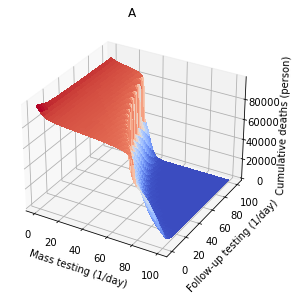

In [36]:
v_a = pd.read_csv('v_a.csv',header=None)       
death_test_fix_a = np.array(v_a)[:,0].reshape((101,101))

from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0,100,101)
Y = np.linspace(0,100,101)
X, Y = np.meshgrid(X, Y)
Z = death_test_fix_a#/1000

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim(0, np.max(death_test_fix_a))

ax.set_xlabel('Mass testing (1/day)')
ax.set_ylabel('Follow-up testing (1/day)')
ax.set_zlabel('Cumulative deaths (person)')
ax.set_title('A')

plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_20_1.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

## ↓(b, m) = (1, 0.04) 

In [33]:
v_b = []

for i in np.linspace(0,1,101):
    for j in np.linspace(0,1,101):
        v_b.append(tSEIRD_max(0.7,0.7,i,j,1,0.04))

np.savetxt('v_b.csv',v_b,delimiter=',')

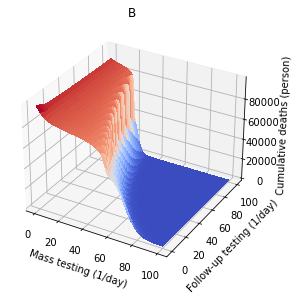

In [34]:
v_b = pd.read_csv('v_b.csv',header=None)       
death_test_fix_b = np.array(v_b)[:,0].reshape((101,101))

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0,100,101)
Y = np.linspace(0,100,101)
X, Y = np.meshgrid(X, Y)
Z = death_test_fix_b#/1000

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim(0, np.max(death_test_fix_b))

ax.set_xlabel('Mass testing (1/day)')
ax.set_ylabel('Follow-up testing (1/day)')
ax.set_zlabel('Cumulative deaths (person)')
ax.set_title('B')

plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_20_1.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

## ↓(b, m) = (1, 0.08) 

In [31]:
v_c = []

for i in np.linspace(0,1,101):
    for j in np.linspace(0,1,101):
        v_c.append(tSEIRD_max(0.7,0.7,i,j,1,0.08))

np.savetxt('v_c.csv',v_c,delimiter=',')

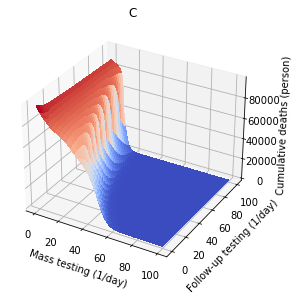

In [32]:
v_c = pd.read_csv('v_c.csv',header=None)              
death_test_fix_c = np.array(v_c)[:,0].reshape((101,101))

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0,100,101)
Y = np.linspace(0,100,101)
X, Y = np.meshgrid(X, Y)
Z = death_test_fix_c#/1000

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim(0, np.max(death_test_fix_c))

ax.set_xlabel('Mass testing (1/day)')
ax.set_ylabel('Follow-up testing (1/day)')
ax.set_zlabel('Cumulative deaths (person)')
ax.set_title('C')

plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_20_1.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

## ↓(b, m) = (1, 0.12) 

In [29]:
v_d = []

for i in np.linspace(0,1,101):
    for j in np.linspace(0,1,101):
        v_d.append(tSEIRD_max(0.7,0.7,i,j,1,0.12))

np.savetxt('v_d.csv',v_d,delimiter=',')

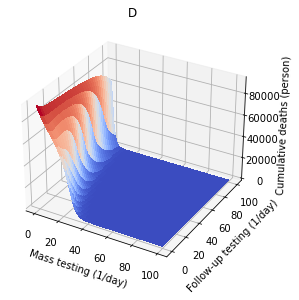

In [30]:
v_d = pd.read_csv('v_d.csv',header=None)      
death_test_fix_d = np.array(v_d)[:,0].reshape((101,101))

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0,100,101)
Y = np.linspace(0,100,101)
X, Y = np.meshgrid(X, Y)
Z = death_test_fix_d#/1000

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim(0, np.max(death_test_fix_d))

ax.set_xlabel('Mass testing (1/day)')
ax.set_ylabel('Follow-up testing (1/day)')
ax.set_zlabel('Cumulative deaths (person)')
ax.set_title('D')

plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_20_1.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

## ↓(b, m) = (1, 0.16) 

In [27]:
v_e = []

for i in np.linspace(0,1,101):
    for j in np.linspace(0,1,101):
        v_e.append(tSEIRD_max(0.7,0.7,i,j,1,0.16))

np.savetxt('v_e.csv',v_e,delimiter=',')

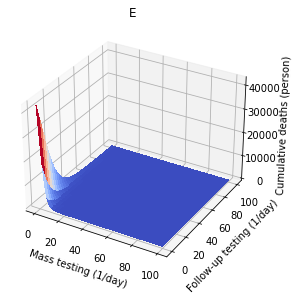

In [28]:
v_e = pd.read_csv('v_e.csv',header=None)
death_test_fix_e = np.array(v_e)[:,0].reshape((101,101))

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0,100,101)
Y = np.linspace(0,100,101)
X, Y = np.meshgrid(X, Y)
Z = death_test_fix_e#/1000

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim(0, np.max(death_test_fix_e))

ax.set_xlabel('Mass testing (1/day)')
ax.set_ylabel('Follow-up testing (1/day)')
ax.set_zlabel('Cumulative deaths (person)')
ax.set_title('E')

plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_20_1.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

## ↓(b, m) = (0.2, 0.04) 

In [25]:
v_f = []

for i in np.linspace(0,1,101):
    for j in np.linspace(0,1,101):
        v_f.append(tSEIRD_max(0.7,0.7,i,j,0.2,0.04))

np.savetxt('v_f.csv',v_f,delimiter=',')

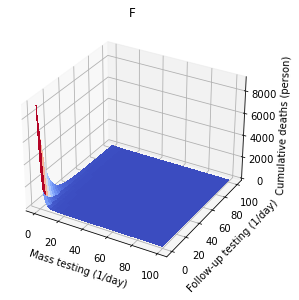

In [26]:
v_f = pd.read_csv('v_f.csv',header=None)             
death_test_fix_f = np.array(v_f)[:,0].reshape((101,101))

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0,100,101)
Y = np.linspace(0,100,101)
X, Y = np.meshgrid(X, Y)
Z = death_test_fix_f

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim(0, np.max(death_test_fix_f))

ax.set_xlabel('Mass testing (1/day)')
ax.set_ylabel('Follow-up testing (1/day)')
ax.set_zlabel('Cumulative deaths (person)')
ax.set_title('F')

plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_20_1.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

## ↓(b, m) = (0.4, 0.04) 

In [23]:
v_g = []

for i in np.linspace(0,1,101):
    for j in np.linspace(0,1,101):
        v_g.append(tSEIRD_max(0.7,0.7,i,j,0.4,0.04))
                
np.savetxt('v_g.csv',v_g,delimiter=',')

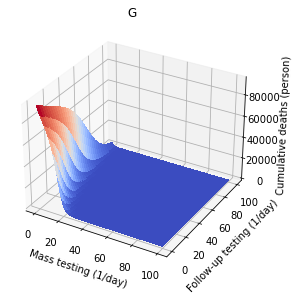

In [24]:
v_g = pd.read_csv('v_g.csv',header=None)     
death_test_fix_g = np.array(v_g)[:,0].reshape((101,101))

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0,100,101)
Y = np.linspace(0,100,101)
X, Y = np.meshgrid(X, Y)
Z = death_test_fix_g

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim(0, np.max(death_test_fix_g))

ax.set_xlabel('Mass testing (1/day)')
ax.set_ylabel('Follow-up testing (1/day)')
ax.set_zlabel('Cumulative deaths (person)')
ax.set_title('G')

plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_20_1.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

## ↓(b, m) = (0.6, 0.04) 

In [21]:
v_h = []

for i in np.linspace(0,1,101):
    for j in np.linspace(0,1,101):
        v_h.append(tSEIRD_max(0.7,0.7,i,j,0.6,0.04))
        
np.savetxt('v_h.csv',v_h,delimiter=',')

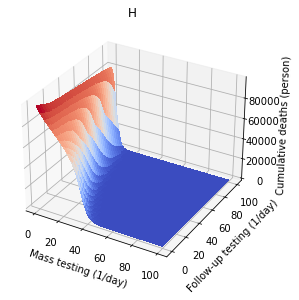

In [22]:
v_h = pd.read_csv('v_h.csv',header=None)        
death_test_fix_h = np.array(v_h)[:,0].reshape((101,101))

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0,100,101)
Y = np.linspace(0,100,101)
X, Y = np.meshgrid(X, Y)
Z = death_test_fix_h

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim(0, np.max(death_test_fix_h))

ax.set_xlabel('Mass testing (1/day)')
ax.set_ylabel('Follow-up testing (1/day)')
ax.set_zlabel('Cumulative deaths (person)')
ax.set_title('H')

plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_20_1.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

## ↓(b, m) = (0.8, 0.04) 

In [19]:
v_i = []

for i in np.linspace(0,1,101):
    for j in np.linspace(0,1,101):
        v_i.append(tSEIRD_max(0.7,0.7,i,j,0.8,0.04))
        
np.savetxt('v_i.csv',v_i,delimiter=',')

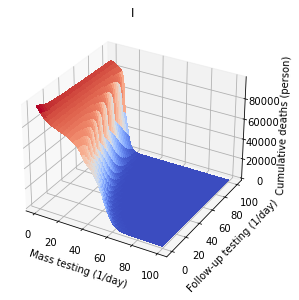

In [20]:
v_i = pd.read_csv('v_i.csv',header=None)        

death_test_fix_i = np.array(v_i)[:,0].reshape((101,101))

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0,100,101)
Y = np.linspace(0,100,101)
X, Y = np.meshgrid(X, Y)
Z = death_test_fix_i#/1000

surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim(0, np.max(death_test_fix_i))

ax.set_xlabel('Mass testing (1/day)')
ax.set_ylabel('Follow-up testing (1/day)')
ax.set_zlabel('Cumulative deaths (person)')
ax.set_title('I')

plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_20_1.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()